In [1]:
#importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Data understading

- importar as bases e entender sobre elas

In [2]:
df_clientes = pd.read_excel(r'/content/dados_clientes.xlsx')
df_clientes.head()

,id_cliente,peso,colesterol,genero,id_estado
0,1,102.0,111,Masculino,23
1,2,115.0,135,Masculino,7
2,3,115.0,136,Masculino,4
3,4,140.0,167,Feminino,24
4,5,130.0,158,Masculino,26


In [3]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_cliente  547 non-null    int64  
 1   peso        542 non-null    float64
 2   colesterol  547 non-null    int64  
 3   genero      547 non-null    object 
 4   id_estado   547 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 21.5+ KB


In [4]:
df_clientes.describe()

,id_cliente,peso,colesterol,id_estado
count,547.00000,542.000000,547.000000,547.000000
mean,274.00000,143.440959,170.433272,13.833638
std,158.04957,30.836868,39.147189,7.593117
min,1.00000,95.000000,102.000000,1.000000
25%,137.50000,116.000000,136.000000,7.000000
50%,274.00000,140.000000,169.000000,13.000000
75%,410.50000,171.000000,208.000000,20.000000
max,547.00000,203.000000,235.000000,27.000000


<Axes: xlabel='colesterol', ylabel='Count'>

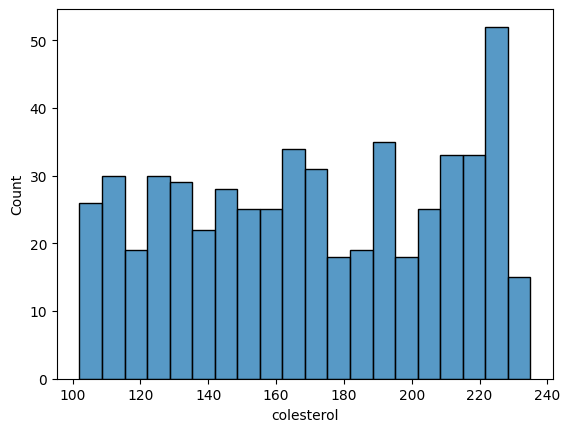

In [5]:
sns.histplot(data = df_clientes, x = 'colesterol', bins= 20)

In [6]:
df_estados = pd.read_csv(r'/content/estados_brasileiros.csv', encoding= "LATIN-1", sep = ';')
df_estados.head()

,id_estado,estado,sigla_estado,pais
0,1,Acre,ac,Brasil
1,2,Alagoas,al,Brasil
2,3,Amapá,ap,Brasil
3,4,Amazonas,am,Brasil
4,5,Bahia,ba,Brasil


In [7]:
df_estados[df_estados.pais.isna()]

,id_estado,estado,sigla_estado,pais
17,18,Piauí,pi,NaN
23,24,Santa Catarina,sc,NaN


In [8]:
df_estados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_estado     27 non-null     int64 
 1   estado        27 non-null     object
 2   sigla_estado  27 non-null     object
 3   pais          25 non-null     object
dtypes: int64(1), object(3)
memory usage: 992.0+ bytes


In [9]:
df_idade = pd.read_csv('/content/idade_clientes.csv', sep = ';')
df_idade.head()

,id_cliente,idade
0,1,17
1,2,28
2,3,62
3,4,55
4,5,44


In [10]:
df_idade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_cliente  547 non-null    int64
 1   idade       547 non-null    int64
dtypes: int64(2)
memory usage: 8.7 KB


# Data preparation
- arrumar os valores nulos: estados - exclusão; variaveis numéricas - mediana; categorica - moda
- unificar todos os datasets em um só
- valores para clusterizar são idade e colesterol

In [11]:
#tirar valores nulos do dataset estados

df_estados.dropna(subset = 'pais', inplace = True)
df_estados.isna().sum()

id_estado       0
estado          0
sigla_estado    0
pais            0
dtype: int64

In [12]:
#colocar o valor da mediana nos valores faltantes do data set de clientes
mediana = df_clientes['peso'].median()
df_clientes.fillna(mediana, inplace = True)
df_clientes.isna().sum()

id_cliente    0
peso          0
colesterol    0
genero        0
id_estado     0
dtype: int64

In [13]:
#unificar com a tabela estados
df_merge1 = pd.merge(df_clientes, df_estados, how = 'left', on ='id_estado')
df_merge1.shape
df_merge1.head()

,id_cliente,peso,colesterol,genero,id_estado,estado,sigla_estado,pais
0,1,102.0,111,Masculino,23,Roraima,rr,Brasil
1,2,115.0,135,Masculino,7,Distrito Federal,df,Brasil
2,3,115.0,136,Masculino,4,Amazonas,am,Brasil
3,4,140.0,167,Feminino,24,NaN,NaN,NaN
4,5,130.0,158,Masculino,26,Sergipe,se,Brasil


In [14]:
#unificar com a tabela idade
df_merge2 = pd.merge(df_merge1, df_idade, how ='left', on ='id_cliente')
print(df_merge2.shape)
df_merge2.head()

(547, 9)


,id_cliente,peso,colesterol,genero,id_estado,estado,sigla_estado,pais,idade
0,1,102.0,111,Masculino,23,Roraima,rr,Brasil,17
1,2,115.0,135,Masculino,7,Distrito Federal,df,Brasil,28
2,3,115.0,136,Masculino,4,Amazonas,am,Brasil,62
3,4,140.0,167,Feminino,24,NaN,NaN,NaN,55
4,5,130.0,158,Masculino,26,Sergipe,se,Brasil,44


In [37]:
#separar as variaveis para a clusterização
var_clust = df_merge2[['idade', 'colesterol']]
var_clust

,idade,colesterol
0,17,111
1,28,135
2,62,136
3,55,167
4,44,158
...,...,...
542,20,207
543,66,157
544,36,115
545,57,147


# Modelagem
- iremos utilizar o numero de cluster como 3

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

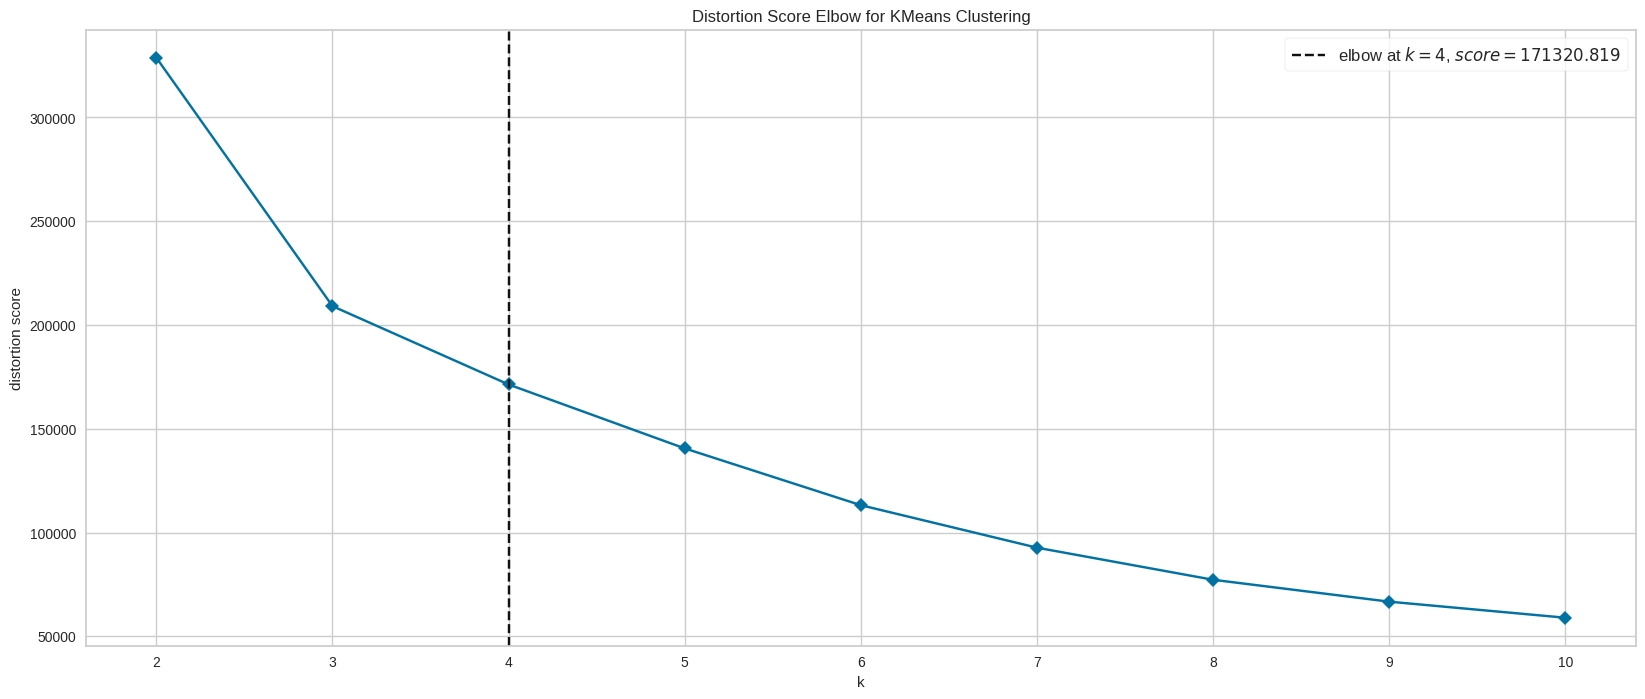

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [39]:
#observar quantos grupos iremos separar
plt.figure(figsize = (20 , 8))
kelbow_visualizer(KMeans(), var_clust, k = 10, timings = False)

In [27]:
#ver os valores de WCSS
for i in range(1,10):
  model_knn = KMeans(n_clusters= i)
  model_knn.fit(var_clust)
  wcss = model_knn.inertia_
  print(f'Número do cluster {i}, valor de WCSS: {wcss}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Número do cluster 1, valor de WCSS: 962234.5557586838
Número do cluster 2, valor de WCSS: 328777.8056539949


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Número do cluster 3, valor de WCSS: 209067.95554334336
Número do cluster 4, valor de WCSS: 171341.02052471723
Número do cluster 5, valor de WCSS: 140575.26174969645
Número do cluster 6, valor de WCSS: 113834.21632183871
Número do cluster 7, valor de WCSS: 92654.85373057038
Número do cluster 8, valor de WCSS: 77098.19857737108
Número do cluster 9, valor de WCSS: 66582.64249146351


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [76]:
#modelagem com 3 clusters
model_knn = KMeans(n_clusters= 3, random_state = 0)
model_knn.fit(var_clust)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [77]:
#criar uma coluna para mostrar quem participa de cada cluster
predi = model_knn.predict(var_clust)
var_clust['cluster'] = predi

<ipython-input-77-336f8b1c9888>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_clust['cluster'] = predi


In [78]:
df_merge2['cluster'] = var_clust['cluster']
df_merge2

,id_cliente,peso,colesterol,genero,id_estado,estado,sigla_estado,pais,idade,cluster
0,1,102.0,111,Masculino,23,Roraima,rr,Brasil,17,1
1,2,115.0,135,Masculino,7,Distrito Federal,df,Brasil,28,1
2,3,115.0,136,Masculino,4,Amazonas,am,Brasil,62,1
3,4,140.0,167,Feminino,24,NaN,NaN,NaN,55,2
4,5,130.0,158,Masculino,26,Sergipe,se,Brasil,44,2
...,...,...,...,...,...,...,...,...,...,...
542,543,172.0,207,Masculino,22,Rondônia,ro,Brasil,20,0
543,544,129.0,157,Masculino,1,Acre,ac,Brasil,66,2
544,545,107.0,115,Masculino,6,Ceará,ce,Brasil,36,1
545,546,117.0,147,Masculino,20,Rio Grande do Norte,rn,Brasil,57,1


<Axes: xlabel='peso', ylabel='colesterol'>

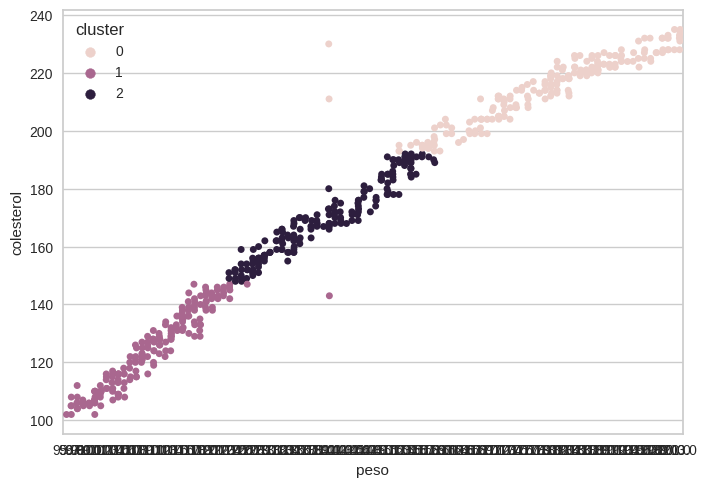

In [79]:
sns.stripplot(data = df_merge2, x = 'peso', y = 'colesterol', hue = 'cluster')

In [80]:
#ver a média de peso/desvio padrao
df_merge2.groupby('cluster')['peso'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,190.0,179.142105,13.789261,140.0,170.25,180.5,189.0,203.0
1,182.0,109.873626,7.975132,95.0,103.00,110.0,116.0,140.0
2,175.0,139.491429,9.908703,123.0,131.00,140.0,149.0,158.0


In [87]:
#ver a quantidade de pessoas por genero em cada um dos clusters
df_merge2.groupby(['cluster','genero'])[['genero']].count()

genero
cluster genero           
0       Feminino       86
        Masculino     104
1       Feminino       80
        Masculino     102
2       Feminino      100
        Masculino      75

In [86]:
#ver qual o estado no cluster de risco moderado que mais tem pessoas
df_estado = df_merge2[df_merge2['cluster'] == 2]
df_estado.groupby(['cluster','estado'])[['genero']].count().sort_values(by = 'genero', ascending = False)

genero
cluster estado                     
2       Mato Grosso do Sul       12
        Goiás                    11
        Minas Gerais             10
        Roraima                  10
        Espírito Santo            9
        Ceará                     8
        Rondônia                  8
        Rio Grande do Sul         8
        Sergipe                   7
        Bahia                     7
        Pernambuco                7
        Pará                      6
        Maranhão                  6
        Alagoas                   6
        Rio Grande do Norte       5
        Acre                      5
        Paraná                    5
        Tocantins                 5
        Rio de Janeiro            4
        Amazonas                  4
        Amapá                     4
        São Paulo                 4
        Paraíba                   3
        Mato Grosso               3
        Distrito Federal          3

In [89]:
#ver qual o estado tem a maior média de colesterol
df_merge2.groupby('estado')['colesterol'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
estado,,,,,,,,
Mato Grosso,18.0,186.333333,34.610437,109.0,166.50,202.5,211.75,222.0
Rio Grande do Sul,21.0,185.380952,34.110814,108.0,168.00,185.0,215.00,224.0
Pernambuco,17.0,180.176471,42.043482,102.0,155.00,187.0,215.00,234.0
Espírito Santo,18.0,179.111111,38.018399,105.0,165.00,180.0,217.50,227.0
Pará,21.0,178.952381,40.092987,106.0,151.00,191.0,213.00,227.0
São Paulo,12.0,176.666667,37.582233,114.0,148.50,182.0,209.50,222.0
Distrito Federal,22.0,175.954545,42.539032,110.0,133.50,194.0,211.75,231.0
Alagoas,21.0,174.666667,42.046799,106.0,139.00,181.0,214.00,228.0
Tocantins,19.0,174.263158,37.716548,110.0,146.00,178.0,200.00,233.0


<Axes: xlabel='peso', ylabel='Count'>

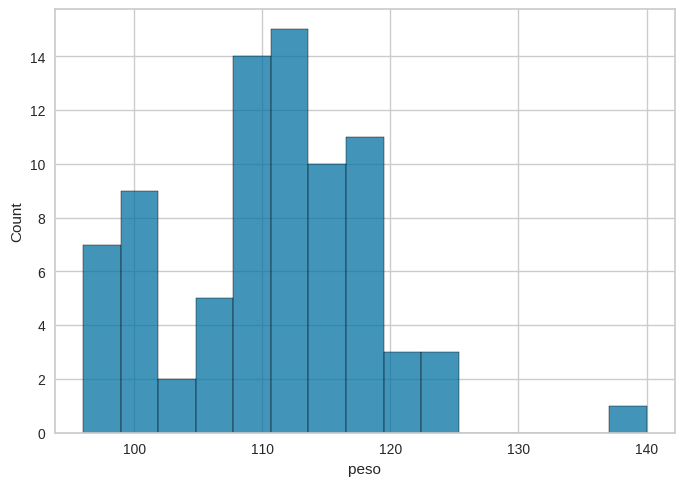

In [97]:
#criar um histograma com pessoas do sexo feminino e a variavel peso
df_feminino = df_merge2[(df_merge2['genero'] == 'Feminino') & (df_merge2['cluster'] == 1)]
sns.histplot(data = df_feminino, x = 'peso', bins = 15)

<Axes: xlabel='cluster', ylabel='idade'>

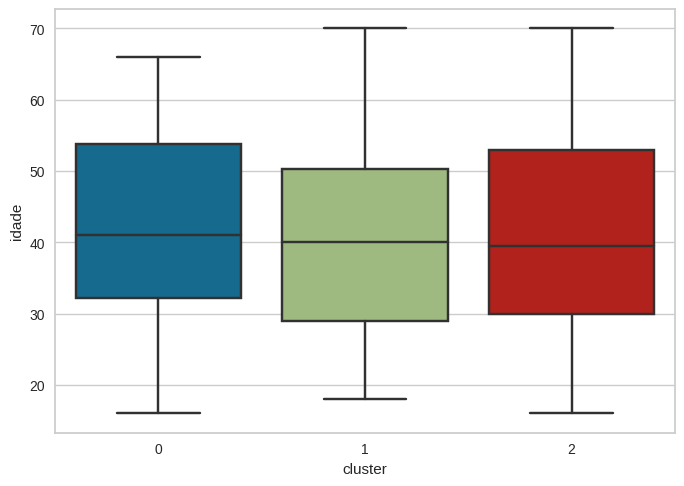

In [99]:
#criar um boxplot do genero feminino por idade
df_idade_fem = df_merge2[df_merge2['genero'] == "Feminino"]
sns.boxplot(data = df_idade_fem, x = 'cluster', y = 'idade')